# Polar plots (azimuth, elevation)

**Links**

- https://pt.wikipedia.org/wiki/Sistema_horizontal_de_coordenadas
- https://matplotlib.org/examples/pylab_examples/polar_demo.html

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
"""
Demo of a line plot on a polar axis.
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def degrees_to_radians(degrees):
    radians = (degrees * np.pi) / 180.0
    return radians
    
def azimuth_to_theta(az):
    '''input:  azimuth (degrees)
       output: angle in radians (radians)'''
    az = degrees_to_radians(az)
    theta = np.pi / 2.0 - az
    return theta

def elevation_to_radius(el):
    '''input:  azimuth (degrees) []
       output: angle in radians (radians)'''
    
    el = abs(el)
    if el > 90.0:
        raise ValueError('Elevation must be in [-90.0, +90.0]')
    radius = 90.0 - el
    return radius

def is_point_visible(y):
    return y >= 0.0

def split_visible_points(x, y):
    visible = []
    invisible = []
    
    for i, yi in enumerate(y):
        point = (x[i], yi)
        if is_point_visible(yi):
            visible.append(point)
        else:
            invisible.append(point)
    return visible, invisible

def az_el_to_theta_radius(az_el):
    theta_radius = tuple((azimuth_to_theta(x), elevation_to_radius(y)) for x, y in az_el)
    return theta_radius

In [3]:
print(azimuth_to_theta(45.0))

0.7853981633974483


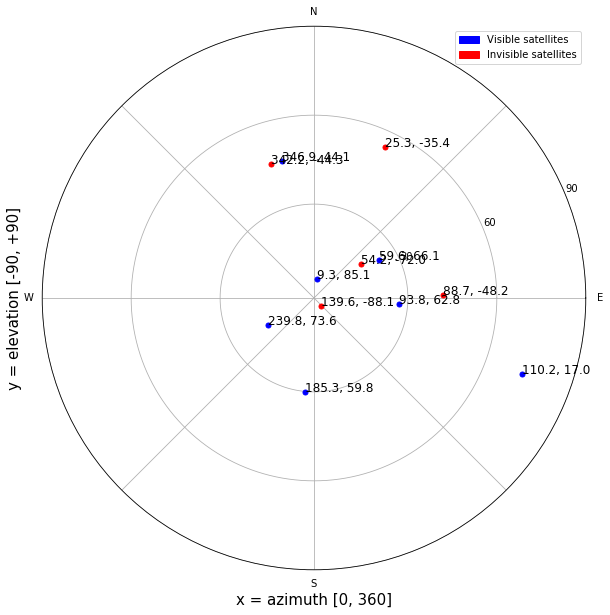

In [6]:
def plot_az_el(az, el):
    plt.figure(num=1, figsize=(10, 10)) 
    
    visible, invisible = split_visible_points(az, el)   
    points_color = {
        'b': az_el_to_theta_radius(visible),
        'r': az_el_to_theta_radius(invisible),
    }
    
    ax = plt.subplot(projection='polar')
    
    for color, points in points_color.items():
        if not points:
            continue 
            
        x, y = list(zip(*points))
        ax.plot(x, y, marker='o', linestyle='', ms=5, color=color)
        
    for i in range(len(az)):
        x = azimuth_to_theta(az[i])
        y = elevation_to_radius(el[i])
        label = '{:.1f}, {:.1f}'.format(az[i], el[i])
        ax.annotate(label, (x, y), fontsize=12)

    ax.set_rticks([30.0, 60.0, 90.0])
    ax.set_xticklabels(['E', '', 'N', '', 'W', '', 'S', ''])
    ax.set_xlabel('x = azimuth [0, 360]', fontsize=15)
    ax.set_ylabel('y = elevation [-90, +90]', fontsize=15, labelpad=20)
    
    visible_patch = mpatches.Patch(color='b', label='Visible satellites')
    invisible_patch = mpatches.Patch(color='r', label='Invisible satellites')
    
    plt.legend(handles=[visible_patch, invisible_patch])

n = 12
az = np.random.uniform(size=n) * 360.0
el = np.random.uniform(low=-1.0, high=1.0, size=n) * 90.0

plot_az_el(az, el) 

### Rastreando N posições do satélite num espaço T de tempo

A biblioteca utilizada tem precisão a partir de 1 segundo. Ou seja, não há como estimar com precisão, utilizando a bibliteca, a posição do satélite em um determinado tempo que não é múltiplo de 1 segundo (por exemplo, 3.14 segundos).

In [10]:
OBS_LAT = -15.989620
OBS_LON = -48.044411
OBS_ALT = 500 # meters

ISS_TLE = ('1 25544U 98067A   18264.87214538 -.00000479 +00000-0 +00000-0 0 9990',
           '2 25544 051.6411 256.8919 0004651 185.2142 246.8508 15.53744581133552')

In [52]:
from datetime import datetime, timedelta, timezone

from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from sgp4.model import Satellite
import pymap3d as pm


def propagate_satellite(satellite, at):
    if not isinstance(satellite, Satellite):
        raise ValueError('sattelite parameter must be an instance of Satellite')
        
    if not (at.tzinfo == timezone.utc):
        raise ValueError('Time must be in UTC')
        
    date_at = at.year, at.month, at.day, at.hour, at.minute, at.second + (at.microsecond / 1000000.0)
    return satellite.propagate(*date_at)

def propagate_satellite_positions(satellite, start=None, count=20, step=1):
    '''Propagates the satellite positions in a equally-distant points in time'''
    if not isinstance(step, int):
        raise ValueError('step must be int')
    if step < 1:
        raise ValueError('step must be >= 1')
    
    if start is None:
        start = datetime.now(timezone.utc)
    
    dates = [start + timedelta(seconds=step * i) for i in range(1, count + 1)]
    positions = [propagate_satellite(satellite, at)[0] for at in dates]

In [13]:
satellite = twoline2rv(ISS_TLE[0], ISS_TLE[1], wgs84)
utc_satview = datetime(year=2018, month=9, day=22, hour=20, minute=37, second=30, tzinfo=timezone.utc)

iss_position, v = propagate_satellite(satellite, utc_satview)
iss_position = (iss_position[0] * 1000.0, iss_position[1] * 1000.0, iss_position[2] * 1000.0)

print('iss_position = {}'.format(iss_position))

iss_position = (768350.0713588104, 6538760.196343955, -1632694.711713458)


In [47]:
propagate_satellite_positions(satellite, start=None, count=20, step=1)

Start = 2018-10-02 21:12:16.320603+00:00
[(6050.762478137116, -163.92359824690828, 3054.8731128178456), (6053.390581705019, -158.66126376500014, 3049.9493059024053), (6056.010944237144, -153.39872638544946, 3045.021587527151), (6058.623562359451, -148.13599283846824, 3040.0899640013663), (6061.228537356312, -142.87285810230168, 3035.1542429851643), (6063.825656267778, -137.60975239868108, 3030.2148279440003), (6066.415020708821, -132.34647071602257, 3025.2715267068297), (6068.996627345133, -127.08301978565007, 3020.324345603145), (6071.570472853378, -121.81940633703897, 3015.373290965515), (6074.136553920171, -116.55563709990382, 3010.418369131517), (6076.694867240544, -111.29171880734663, 3005.4595864466987), (6079.245409522031, -106.02765818746765, 3000.496949256701), (6081.788279625833, -100.76325017778838, 2995.5302640241102), (6084.323269671875, -95.49892509809894, 2990.5599367400755), (6086.850478855198, -90.23447788951059, 2985.585774029837), (6089.3699039226685, -84.96991528203

In [50]:
a = np.array([i for i in range(5)])
a * 5

array([ 0,  5, 10, 15, 20])